**Import statements**


In [95]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.linear_model import PassiveAggressiveRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
from statsmodels.tsa.arima_model import ARMA


import constants
import functions5 as functions

flatten = lambda l: [item for sublist in l for item in sublist]


%matplotlib inline

**Load Data**

In [96]:
all_static_data = functions.load_static_sensors_calibrated_2()
all_static_data = functions.transform_to_grid_coordinates(all_static_data)
mobile_sensor_data = functions.load_mobile_sensors_2()
mobile_sensor_data = functions.transform_to_grid_coordinates(mobile_sensor_data)

**Compute predictions for stationary sensors**

In [97]:
# Fazer filtro de 1 hora ou assim
def within_minutes(x, time, limite=60):
    #return datetime.strptime(time, '%Y-%m-%d %H:%M:%S') - timedelta(minutes=limite) < datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
     return True
    
def correct(pred_value, error_dict, time=None):
    error_dict = [y for x,y in error_dict if within_minutes(x, time, limite=60)]
    if len(error_dict) < 1 :
        return pred_value
    new_value = pred_value + np.mean(error_dict)
    # new_value = pred_value + max(error_dict, key=lambda item:item[0])[1]
    return max(0.0, new_value)

In [101]:
# Correct with ML version
def correct(pred_value, error_dict, time=None):
    errors = [y for x,y in error_dict if within_minutes(x, time, limite=60)]
    dates = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x,y in error_dict if within_minutes(x, time, limite=60)]
    
    if len(errors) < 3 :
        return pred_value
    
    step_zero = min(dates)
    int_dates= [int((x-step_zero).seconds/60/15) for x in dates]
    int_time = int((datetime.strptime(time, '%Y-%m-%d %H:%M:%S')-step_zero).seconds/60/15) 
    
    regr = LinearRegression()
    # regr = PassiveAggressiveRegressor(max_iter=100, random_state=0, tol=1e-3)
    regr.fit(np.array(int_dates).reshape(-1, 1),errors)
    correction = regr.predict([[int_time]])
    
    new_value = pred_value + correction
    # new_value = pred_value + max(error_dict, key=lambda item:item[0])[1]
    return max(0.0, new_value)

In [102]:
def find_neighbors(mat, i, j, dist=1):
    neighbors = []
    i_min = max(0, i-dist)
    i_max = i+dist+1
    j_min = max(0, j-dist)
    j_max = j+dist+1
    for row in mat[i_min:i_max]:
        neighbors.append(row[j_min:j_max])
    return neighbors

In [116]:
mae = []
mse = []
squares = []

start_time = '2018-07-23 00:00:00'
start_window = '2018-07-26 13:45:00'
end_window = '2018-07-26 14:00:00'

number_of_windows = 3
window = 15
par_grid = functions.create_par(c=0.00002, epsilon=0.001)

# Load the 1st dataset pickle file
grid_of_errors = pickle.load( open( "tmp_error_grid/grid_of_errors.p", "rb" ) )
# Empty error grid
#grid_of_errors = [[[] for x in range(20)] for y in range(20)]

timeint_on_first_window = 0
tmp_to_test_filename = 'tmp_to_test/with_mobile_data_{}_{}.csv'.format(start_window, number_of_windows)

for i in range(1, number_of_windows+1):
    end_time = start_window
    # treinar sem dados moveis
    # testar em dados fixos em vez de móveis
    #print(start_window)
    #print(end_window)
    timeint, par_grid, grid_of_errors = functions.train(all_static_data, mobile_sensor_data, start_time, end_time, par_grid, window, grid_of_errors, timeint_on_first_window)
    to_test = functions.test_mobile(par_grid, timeint, mobile_sensor_data, start_window, end_window, 1)
    #print(to_test)
    
    # Calcular o erro numa das colunas do to_test
    to_test['error_PM2.5'] = to_test['PM2.5'] - to_test['pred_PM2.5']
    to_test['start_window'] = start_window
    
    # Guardar os erros raw numa coluna pq depois vou descontar os bias na pred_PM2.5
    to_test['pred_PM2.5_raw'] = to_test['pred_PM2.5']
    
    # Guardar o tempo em que aconteceu
    to_test['Timestamp'] = start_window
    
    # Corrigir as previsões com os erros
    for index, row in to_test.iterrows():
        # aplicar a função correct que aplica a função mean
        # Fazer aqui o alargamento dos erros.
        errors = flatten(flatten(find_neighbors(grid_of_errors, row['lat_grid'], row['long_grid'])))
        to_test.at[index, 'pred_PM2.5'] = correct(row['pred_PM2.5'], errors, time=start_window)
        
    # Meter os erros na grid
    for index, row in to_test.iterrows():
        #O uso de index deve ser mudado para o timestamp
        grid_of_errors[int(row['lat_grid'])][int(row['long_grid'])].append((row['start_window'], row['error_PM2.5']))
        if len(grid_of_errors[int(row['lat_grid'])][int(row['long_grid'])]) > 10:
            grid_of_errors[int(row['lat_grid'])][int(row['long_grid'])].pop(0)
    
    
    squares.append(to_test.shape[0])
    mae.append(mean_absolute_error(to_test['PM2.5'], to_test['pred_PM2.5']))
    mse.append(mean_squared_error(to_test['PM2.5'], to_test['pred_PM2.5']))

    start_time = end_time
    start_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")
    end_window = (datetime.strptime(end_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")
    timeint_on_first_window = timeint+1
    

In [117]:
#grid_of_errors[5][12]


In [118]:
print(mae)
print(squares)

[2.395831210560869, 1.9728488503274193, 1.13831175662127]
[10, 44, 5]


In [119]:
lens=[]
maxi = 1
max_i = 0
max_j = 0
for i in range(20):
    for j in range(20):
        lens.append(len(grid_of_errors[i][j]))
        if maxi <= len(grid_of_errors[i][j]):
            max_i = i
            max_j = j
            maxi = len(grid_of_errors[i][j])
            print("-----------")
            print ("i: {}\nj: {}\nmax: {} ".format(max_i,max_j, maxi))
            print("-----------")

-----------
i: 0
j: 7
max: 2 
-----------
-----------
i: 0
j: 11
max: 5 
-----------
-----------
i: 1
j: 10
max: 8 
-----------
-----------
i: 2
j: 9
max: 9 
-----------
-----------
i: 3
j: 7
max: 10 
-----------
-----------
i: 4
j: 11
max: 10 
-----------
-----------
i: 4
j: 12
max: 13 
-----------
-----------
i: 5
j: 12
max: 16 
-----------


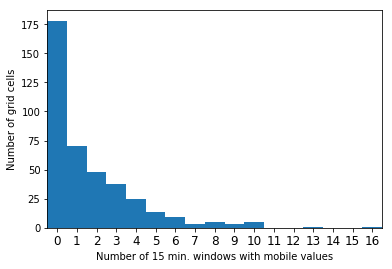

In [123]:
bins = range(18)
plt.hist(lens, align='mid', bins = bins)
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])
bins_labels(bins, fontsize=12)
plt.xlabel("Number of 15 min. windows with mobile values")
plt.ylabel("Number of grid cells")
plt.show()

Previsao

tiro lhe a media do erro

essa e a minha real previsao

guardar na estrutura o erro obtido ANTES da subtração da media do erro



ver a noçao de locality

olhar para a previsao de celulas adjacentes e erro de celulas adjacentes